In [1]:
import pandas as pd
import spacy

nlp = spacy.load('en_core_web_sm') # load the model

text = 'right ones in the right order you can nudge the world'
doc = nlp(text)
doc

right ones in the right order you can nudge the world

In [5]:
[getattr(term, 'text') for term in doc]

['right',
 'ones',
 'in',
 'the',
 'right',
 'order',
 'you',
 'can',
 'nudge',
 'the',
 'world']

In [4]:
[{ key: getattr(term, key) for key in ['text', 'pos_']} for term in doc]

[{'text': 'right', 'pos_': 'ADJ'},
 {'text': 'ones', 'pos_': 'NOUN'},
 {'text': 'in', 'pos_': 'ADP'},
 {'text': 'the', 'pos_': 'DET'},
 {'text': 'right', 'pos_': 'ADJ'},
 {'text': 'order', 'pos_': 'NOUN'},
 {'text': 'you', 'pos_': 'PRON'},
 {'text': 'can', 'pos_': 'AUX'},
 {'text': 'nudge', 'pos_': 'VERB'},
 {'text': 'the', 'pos_': 'DET'},
 {'text': 'world', 'pos_': 'NOUN'}]

Build a DataFrame of terms and parts of speech.

In [7]:
df = pd.DataFrame([{ key: getattr(term, key) for key in ['text', 'pos_']} for term in doc])
df

,text,pos_
0,right,ADJ
1,ones,NOUN
2,in,ADP
3,the,DET
4,right,ADJ
5,order,NOUN
6,you,PRON
7,can,AUX
8,nudge,VERB
9,the,DET


One-hot encoding

In [8]:
pd.get_dummies(df, columns=['pos_'], prefix='', prefix_sep='')

,text,ADJ,ADP,AUX,DET,NOUN,PRON,VERB
0,right,True,False,False,False,False,False,False
1,ones,False,False,False,False,True,False,False
2,in,False,True,False,False,False,False,False
3,the,False,False,False,True,False,False,False
4,right,True,False,False,False,False,False,False
5,order,False,False,False,False,True,False,False
6,you,False,False,False,False,False,True,False
7,can,False,False,True,False,False,False,False
8,nudge,False,False,False,False,False,False,True
9,the,False,False,False,True,False,False,False


Create a filter to match adverbs using spacy's POS tagging.

In [9]:
quote = 'The right word may be effective, but no word was ever as effective as a rightly timed pause.'
tagged_words = {
    t.text: [t.pos_, int(t.pos_ == 'ADV')] for t in nlp(quote)
}
tagged_words

{'The': ['DET', 0],
 'right': ['ADJ', 0],
 'word': ['NOUN', 0],
 'may': ['AUX', 0],
 'be': ['AUX', 0],
 'effective': ['ADJ', 0],
 ',': ['PUNCT', 0],
 'but': ['CCONJ', 0],
 'no': ['DET', 0],
 'was': ['AUX', 0],
 'ever': ['ADV', 1],
 'as': ['ADP', 0],
 'a': ['DET', 0],
 'rightly': ['ADV', 1],
 'timed': ['VERB', 0],
 'pause': ['NOUN', 0],
 '.': ['PUNCT', 0]}

In [10]:
df_quote = pd.DataFrame(tagged_words, index=['POS', 'ADV'])
df_quote

,The,right,word,may,be,effective,",",but,no,was,ever,as,a,rightly,timed,pause,.
POS,DET,ADJ,NOUN,AUX,AUX,ADJ,PUNCT,CCONJ,DET,AUX,ADV,ADP,DET,ADV,VERB,NOUN,PUNCT
ADV,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [11]:
inpt = list(df_quote.loc['ADV'])
inpt

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

In [21]:
kernel_ = [.5, .5]

output = []
for i in range(len(inpt) - 1):
    z = 0
    for k, weight in enumerate(kernel_):
        z += inpt[i + k] * weight # apply kernel over the input i and i + 1
    output.append(z)

In [22]:
print(f'input: {inpt}')
print(f'output: {output}')

input: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
output: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 0.0]


Numpy implementation

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 120

import seaborn as sns
sns.set_theme('paper')

df = pd.DataFrame([inpt, output], index=['input', 'output']).T
df

,input,output
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.5


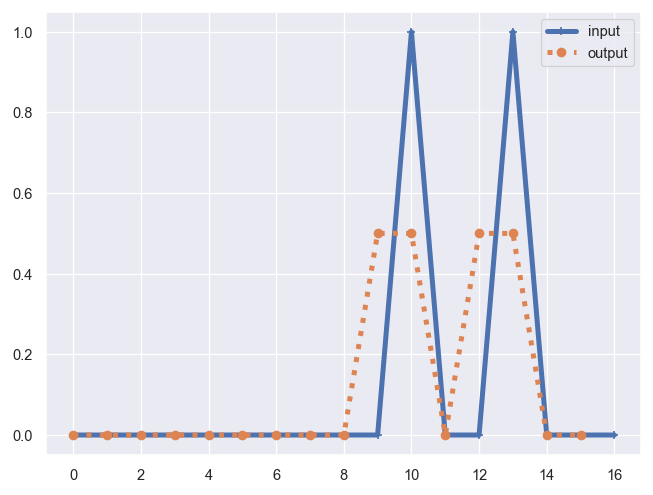

In [24]:
ax = df.plot(style=['+-', 'o:'], linewidth=3)

In [25]:
def convolve(inpt, kernel):
    output = []
    for i in range(len(inpt) - len(kernel) + 1):
        output.append(
            sum(
                [
                    inpt[i + k] * kernel[k] for k in range(len(kernel))
                ]
            )
        )
    return output

Pytorch 1D convolution

In [27]:
tags = ['ADV', 'ADJ', 'VERB', 'NOUN']
tagged_words = [
    [token.text] + [int(token.pos_ == tag) for tag in tags]
    for token in nlp(quote)
]
df = pd.DataFrame(tagged_words, columns=['token'] + tags).T
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
token,The,right,word,may,be,effective,",",but,no,word,was,ever,as,effective,as,a,rightly,timed,pause,.
ADV,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
ADJ,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
VERB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
NOUN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [28]:
import torch
x = torch.tensor(
    df.iloc[1:].astype(float).values,
    dtype=torch.float32
)
x = x.unsqueeze(0)
x

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
          0., 0., 0.],
         [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0.]]])

In [29]:
kernel_ = pd.DataFrame(
    [[1, 0, 0],
     [0, 0, 0], 
     [0, 1, 0],
     [0, 0, 1]], index=tags
)
kernel_

,0,1,2
ADV,1,0,0
ADJ,0,0,0
VERB,0,1,0
NOUN,0,0,1


In [30]:
kernel_ = torch.tensor(kernel_.values, dtype=torch.float32)
kernel_ = kernel_.unsqueeze(0)
conv = torch.nn.Conv1d(in_channels=4, out_channels=1, kernel_size=3, bias=False)
conv.load_state_dict({'weight': kernel_})
print(conv.weight)

Parameter containing:
tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], requires_grad=True)


In [31]:
import numpy as np
y = np.array(conv.forward(x).detach()).squeeze()
y

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 3.,
       0.], dtype=float32)

In [32]:
df.loc['y'] = pd.Series(y)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
token,The,right,word,may,be,effective,",",but,no,word,was,ever,as,effective,as,a,rightly,timed,pause,.
ADV,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
ADJ,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
VERB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
NOUN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN


# Morse code

In [34]:
from nlpia2.init import maybe_download

url = 'https://upload.wikimedia.org/wikipedia/commons/7/78/1210secretmorzecode.wav'
filepath = maybe_download(url, '1210secretmorzecode.wav')
filepath

filename: 1210secretmorzecode.wav
src_filepath: C:\Users\lived\.nlpia2-data\1210secretmorzecode.wav
home_filepath: C:\Users\lived\.nlpia2-data\1210secretmorzecode.wav
src_filepath.is_file(): False


'C:\\Users\\lived\\.nlpia2-data\\1210secretmorzecode.wav'

In [35]:
from scipy.io import wavfile

sample_rate, audio = wavfile.read(filepath)
print(f'sample_rate: {sample_rate}')
print(f'audio: {audio}')

sample_rate: 4000
audio: [255   0 255 ...   0 255   0]


In [36]:
pd.options.display.max_rows = 10

audio = audio[:sample_rate * 2] # #1  
audio = np.abs(audio - audio.max() / 2) - .5 # #2  
audio = audio / audio.max() # #3  
audio = audio[::sample_rate // 400] # #4  
audio = pd.Series(audio, name='audio')  
audio.index = 1000 * audio.index / sample_rate # #5  
audio.index.name = 'time (ms)'  
print(f'audio:\n{audio}')

audio:
time (ms)
0.00      1.0
0.25      1.0
0.50      1.0
0.75      1.0
1.00      1.0
         ... 
198.75    0.0
199.00    0.0
199.25    0.0
199.50    0.0
199.75    0.0
Name: audio, Length: 800, dtype: float64


<Axes: xlabel='time (ms)'>

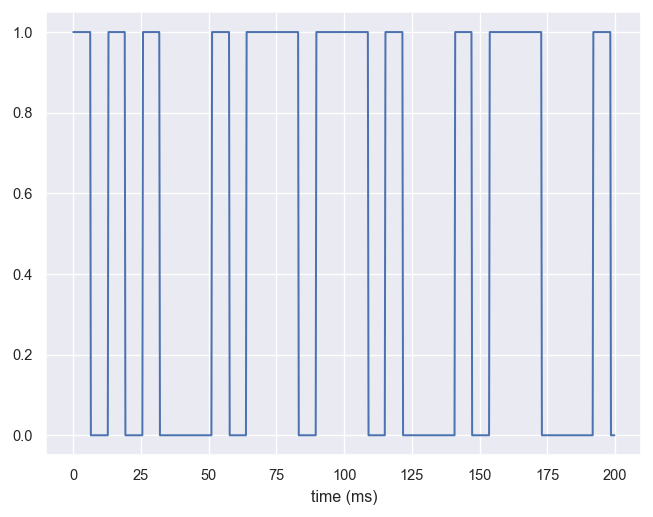

In [37]:
audio.plot()

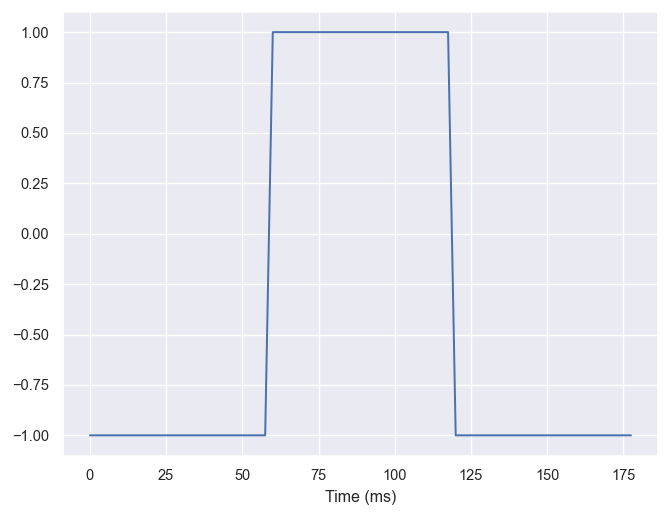

In [44]:
kernel_ = [-1] * 24 + [1] * 24 + [-1] * 24
kernel_ = pd.Series(kernel_, index=2.5 * np.arange(len(kernel_)))
kernel_.index.name = 'Time (ms)'
ax = kernel_.plot()

In [45]:
kernel_

Time (ms)
0.0     -1
2.5     -1
5.0     -1
7.5     -1
10.0    -1
        ..
167.5   -1
170.0   -1
172.5   -1
175.0   -1
177.5   -1
Length: 72, dtype: int64

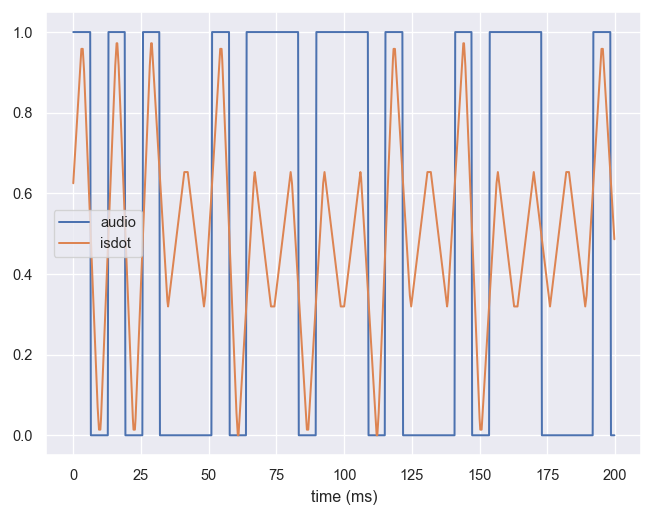

In [56]:
kernel = np.array(kernel_) / sum(np.abs(kernel_))  # #1

isdot = np.convolve(audio.values, kernel, mode='same')
df['isdot'] = isdot - isdot.min()
ax = df.plot()